In [1]:
import sys

sys.path.append('../../IPYNB/DataPreparation')

from Preparation import CustomDataLoader

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn.functional as F

In [3]:
# Define the data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [4]:
# training data properties
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 4

test_data_loader = CustomDataLoader(data_path="../../all_data/data", batch_size=BATCH_SIZE, dataset_type="test", mean=MEAN, std=STD).data_loader

In [5]:
# Define F2 Evaluation score
def f2_score(precision, recall):
    
    # Beta value for F2 score
    beta = 2
    
    # F2 score formula
    f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    
    return f2_score


In [6]:
import torch

def adjust_weights_based_on_f1(model1_f1, model2_f1):
    # Calculate inverses of F1 scores
    inverse_model1_f1 = 1 / model1_f1
    inverse_model2_f1 = 1 / model2_f1
    
    # Normalize inverses
    total_inverse = inverse_model1_f1 + inverse_model2_f1
    weight_model1 = inverse_model1_f1 / total_inverse
    weight_model2 = inverse_model2_f1 / total_inverse
    
    return weight_model1, weight_model2

def ensemble_predict(model1, model2, dataloader, model1_f1=None, model2_f1=None):
    ens_predictions = []
    true_label = []
    model1_predictions = []
    model2_predictions = []
    weights = None
    
    # Adjust weights based on F1 scores if provided
    if model1_f1 is not None and model2_f1 is not None:
        weights = adjust_weights_based_on_f1(model1_f1, model2_f1)
    elif weights is None:
        weights = [0.5, 0.5]  # Default weights if not provided
    
    for inputs, labels in dataloader:        
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        
        # Weighted averaging
        weighted_outputs = (outputs1 * weights[0]) + (outputs2 * weights[1])
        
        ens_predictions.extend(torch.max(weighted_outputs, 1)[1].tolist())
        true_label.extend(labels.tolist())
        model1_predictions.extend(torch.max(outputs1, 1)[1].tolist())
        model2_predictions.extend(torch.max(outputs2, 1)[1].tolist())
        
    return {
        'ensemble_pred': ens_predictions,
        'label': true_label,
        '1_pred': model1_predictions,
        '2_pred': model2_predictions
    }


In [7]:
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score


# Load the saved models
vgg19_path = '../../models/02-25-2024/lr_0.0001/vgg19_epoch_15.pt'  # Adjust the path as per your saved model
resnet50_path = '../../models/02-25-2024/lr_0.0001/resnet50_epoch_15.pt'  # Adjust the path as per your saved model

# Define the VGG-19 model architecture
vgg19_model = models.vgg19(pretrained=False)

# Modify the classifier layer for 2 classes
vgg19_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# Load the parameters into the model
state_dict = torch.load(vgg19_path)
# Remove classifier parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'classifier' in key:
        del state_dict[key]
vgg19_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
vgg19_model.eval()


# Define the ResNet-50 model architecture
resnet50_model = models.resnet50(pretrained=False)

# Modify the last fully connected layer for 2 classes
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(num_ftrs, 2)

# Load the parameters into the model
state_dict = torch.load(resnet50_path)
# Remove fc parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'fc' in key:
        del state_dict[key]
resnet50_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
resnet50_model.eval()


c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Test 1

In [20]:
import time
# Check if a GPU is available and set the device accordingly
device = torch.device("cpu")

# Function to perform ensemble prediction and measure inference time
def ensemble_predict(vgg_model, resnet_model, test_loader):
    predictions = {'label': [], '1_pred': [], '2_pred': [], 'ensemble_pred': []}
    total_vgg_time = 0  # To track the total inference time for VGG-19
    total_resnet_time = 0  # To track the total inference time for ResNet-50
    total_ensemble_time = 0  # To track the total ensemble inference time
    
    with torch.no_grad():
        for data, target in test_loader:
            start_ensemble_time = time.time()
            data = data.to(device)  # Move data to the same device as the models (GPU/CPU)
            target = target.to(device)  # Move labels to the device
            
            # Measure time for VGG-19 prediction
            start_vgg_time = time.time()
            vgg_output = vgg_model(data)
            end_vgg_time = time.time()
            total_vgg_time += (end_vgg_time - start_vgg_time)
            _, vgg_pred = torch.max(vgg_output, 1)
            
            # Measure time for ResNet-50 prediction
            start_resnet_time = time.time()
            resnet_output = resnet_model(data)
            end_resnet_time = time.time()
            total_resnet_time += (end_resnet_time - start_resnet_time)
            _, resnet_pred = torch.max(resnet_output, 1)
            
            # Measure time for ensemble prediction
            
            ensemble_pred = (vgg_output + resnet_output) / 2
            end_ensemble_time = time.time()
            total_ensemble_time += (end_ensemble_time - start_ensemble_time)
            _, final_ensemble_pred = torch.max(ensemble_pred, 1)
            
            # Store predictions
            predictions['label'].extend(target.cpu().tolist())
            predictions['1_pred'].extend(vgg_pred.cpu().tolist())
            predictions['2_pred'].extend(resnet_pred.cpu().tolist())
            predictions['ensemble_pred'].extend(final_ensemble_pred.cpu().tolist())
    
    # Return predictions and the individual model inference times
    return predictions, total_vgg_time, total_resnet_time, total_ensemble_time

# Perform ensemble prediction and measure total inference times for both models and the ensemble
ensemble_predictions, total_vgg_time, total_resnet_time, total_ensemble_time = ensemble_predict(vgg19_model, resnet50_model, test_data_loader)

# Calculate total number of images in the test dataset
num_images = len(ensemble_predictions['label'])

# Calculate average inference time per image for VGG-19, ResNet-50, and the ensemble
average_vgg_inference_time = total_vgg_time / num_images
average_resnet_inference_time = total_resnet_time / num_images
average_ensemble_inference_time = total_ensemble_time / num_images

# Print the average inference times
print(f"VGG-19 average inference time per image: {average_vgg_inference_time:.6f} seconds")
print(f"ResNet-50 average inference time per image: {average_resnet_inference_time:.6f} seconds")
print(f"Ensemble average inference time per image: {average_ensemble_inference_time:.6f} seconds")

# Proceed with evaluating models and computing metrics
vgg_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_f2 = f2_score(vgg_precision, vgg_recall)
resnet_f2 = f2_score(resnet_precision, resnet_recall)
vgg_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['2_pred'])

ensemble_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])
ensemble_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_f2 = f2_score(ensemble_precision, ensemble_recall)

print("********************************")
print(f'Ensemble F2 score: {ensemble_f2}')
print(f'VGG-19 F2 score: {vgg_f2}')
print(f'ResNet-50 F2 score: {resnet_f2}')
print("********************************")
print(f'Ensemble accuracy: {ensemble_acc}')
print(f'VGG-19 accuracy: {vgg_acc}')
print(f'ResNet-50 accuracy: {resnet_acc}')
print("********************************")
print(f'Ensemble recall: {ensemble_recall}')
print(f'VGG-19 recall: {vgg_recall}')
print(f'ResNet-50 recall: {resnet_recall}')
print("********************************")
print(f'Ensemble precison: {ensemble_precision}')
print(f'VGG-19 precision: {vgg_precision}')
print(f'ResNet-50 precision: {resnet_precision}')

VGG-19 average inference time per image: 0.048221 seconds
ResNet-50 average inference time per image: 0.021552 seconds
Ensemble average inference time per image: 0.069773 seconds
********************************
Ensemble F2 score: 0.39501404494382025
VGG-19 F2 score: 0.35040431266846356
ResNet-50 F2 score: 0.5
********************************
Ensemble accuracy: 0.4090909090909091
VGG-19 accuracy: 0.36363636363636365
ResNet-50 accuracy: 0.5
********************************
Ensemble recall: 0.4090909090909091
VGG-19 recall: 0.36363636363636365
ResNet-50 recall: 0.5
********************************
Ensemble precison: 0.3472222222222222
VGG-19 precision: 0.3058823529411765
ResNet-50 precision: 0.5


<Figure size 600x600 with 0 Axes>

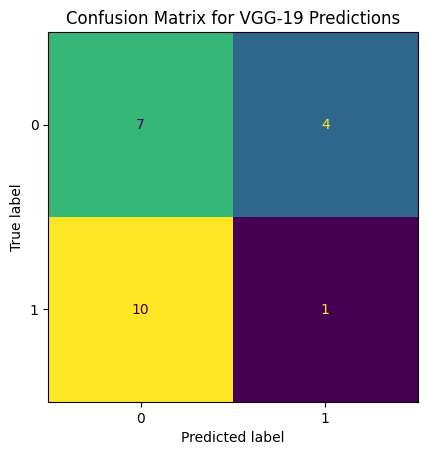

<Figure size 600x600 with 0 Axes>

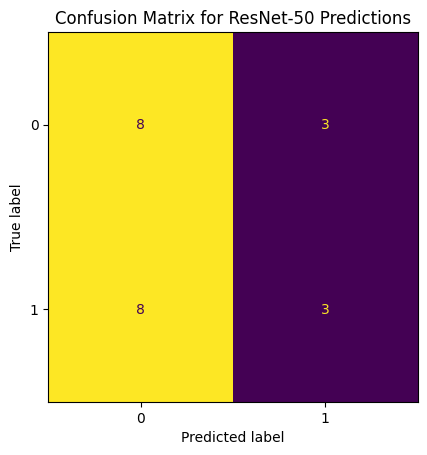

<Figure size 600x600 with 0 Axes>

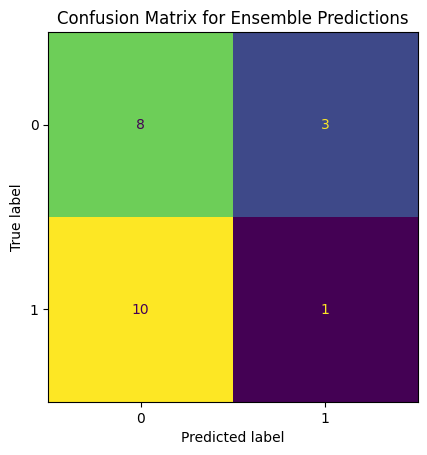

In [21]:
# Compute confusion matrices for each model
vgg_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['2_pred'])
ensemble_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])

# Plot confusion matrix for VGG-19
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=vgg_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for VGG-19 Predictions")
plt.show()

# Plot confusion matrix for ResNet-50
plt.figure(figsize=(6, 6))
resnet_disp = ConfusionMatrixDisplay(confusion_matrix=resnet_conf_matrix)
resnet_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for ResNet-50 Predictions")
plt.show()

# Plot confusion matrix for Ensemble
plt.figure(figsize=(6, 6))
ensemble_disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_conf_matrix)
ensemble_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Ensemble Predictions")
plt.show()

#### Test 2

In [22]:
import time
# Check if a GPU is available and set the device accordingly
device = torch.device("cpu")

# Function to perform ensemble prediction and measure inference time
def ensemble_predict(vgg_model, resnet_model, test_loader):
    predictions = {'label': [], '1_pred': [], '2_pred': [], 'ensemble_pred': []}
    total_vgg_time = 0  # To track the total inference time for VGG-19
    total_resnet_time = 0  # To track the total inference time for ResNet-50
    total_ensemble_time = 0  # To track the total ensemble inference time
    
    with torch.no_grad():
        for data, target in test_loader:
            start_ensemble_time = time.time()
            data = data.to(device)  # Move data to the same device as the models (GPU/CPU)
            target = target.to(device)  # Move labels to the device
            
            # Measure time for VGG-19 prediction
            start_vgg_time = time.time()
            vgg_output = vgg_model(data)
            end_vgg_time = time.time()
            total_vgg_time += (end_vgg_time - start_vgg_time)
            _, vgg_pred = torch.max(vgg_output, 1)
            
            # Measure time for ResNet-50 prediction
            start_resnet_time = time.time()
            resnet_output = resnet_model(data)
            end_resnet_time = time.time()
            total_resnet_time += (end_resnet_time - start_resnet_time)
            _, resnet_pred = torch.max(resnet_output, 1)
            
            # Measure time for ensemble prediction
            
            ensemble_pred = (vgg_output + resnet_output) / 2
            end_ensemble_time = time.time()
            total_ensemble_time += (end_ensemble_time - start_ensemble_time)
            _, final_ensemble_pred = torch.max(ensemble_pred, 1)
            
            # Store predictions
            predictions['label'].extend(target.cpu().tolist())
            predictions['1_pred'].extend(vgg_pred.cpu().tolist())
            predictions['2_pred'].extend(resnet_pred.cpu().tolist())
            predictions['ensemble_pred'].extend(final_ensemble_pred.cpu().tolist())
    
    # Return predictions and the individual model inference times
    return predictions, total_vgg_time, total_resnet_time, total_ensemble_time

# Perform ensemble prediction and measure total inference times for both models and the ensemble
ensemble_predictions, total_vgg_time, total_resnet_time, total_ensemble_time = ensemble_predict(vgg19_model, resnet50_model, test_data_loader)

# Calculate total number of images in the test dataset
num_images = len(ensemble_predictions['label'])

# Calculate average inference time per image for VGG-19, ResNet-50, and the ensemble
average_vgg_inference_time = total_vgg_time / num_images
average_resnet_inference_time = total_resnet_time / num_images
average_ensemble_inference_time = total_ensemble_time / num_images

# Print the average inference times
print(f"VGG-19 average inference time per image: {average_vgg_inference_time:.6f} seconds")
print(f"ResNet-50 average inference time per image: {average_resnet_inference_time:.6f} seconds")
print(f"Ensemble average inference time per image: {average_ensemble_inference_time:.6f} seconds")

# Proceed with evaluating models and computing metrics
vgg_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_f2 = f2_score(vgg_precision, vgg_recall)
resnet_f2 = f2_score(resnet_precision, resnet_recall)
vgg_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['2_pred'])

ensemble_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])
ensemble_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_f2 = f2_score(ensemble_precision, ensemble_recall)

print("********************************")
print(f'Ensemble F2 score: {ensemble_f2}')
print(f'VGG-19 F2 score: {vgg_f2}')
print(f'ResNet-50 F2 score: {resnet_f2}')
print("********************************")
print(f'Ensemble accuracy: {ensemble_acc}')
print(f'VGG-19 accuracy: {vgg_acc}')
print(f'ResNet-50 accuracy: {resnet_acc}')
print("********************************")
print(f'Ensemble recall: {ensemble_recall}')
print(f'VGG-19 recall: {vgg_recall}')
print(f'ResNet-50 recall: {resnet_recall}')
print("********************************")
print(f'Ensemble precison: {ensemble_precision}')
print(f'VGG-19 precision: {vgg_precision}')
print(f'ResNet-50 precision: {resnet_precision}')

VGG-19 average inference time per image: 0.051039 seconds
ResNet-50 average inference time per image: 0.018999 seconds
Ensemble average inference time per image: 0.070129 seconds
********************************
Ensemble F2 score: 0.5783132530120483
VGG-19 F2 score: 0.454233801851217
ResNet-50 F2 score: 0.6203817733990148
********************************
Ensemble accuracy: 0.5454545454545454
VGG-19 accuracy: 0.45454545454545453
ResNet-50 accuracy: 0.5909090909090909
********************************
Ensemble recall: 0.5454545454545454
VGG-19 recall: 0.45454545454545453
ResNet-50 recall: 0.5909090909090909
********************************
Ensemble precison: 0.761904761904762
VGG-19 precision: 0.452991452991453
ResNet-50 precision: 0.775


<Figure size 600x600 with 0 Axes>

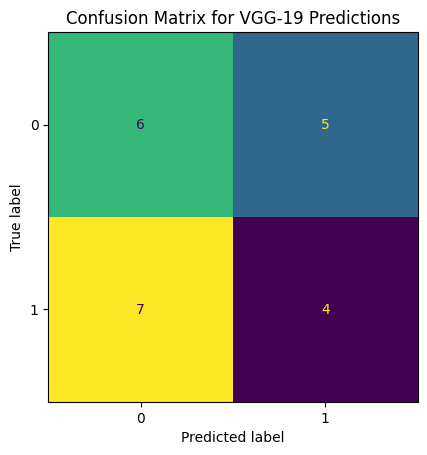

<Figure size 600x600 with 0 Axes>

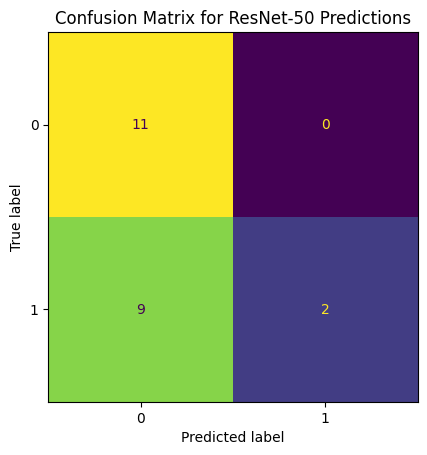

<Figure size 600x600 with 0 Axes>

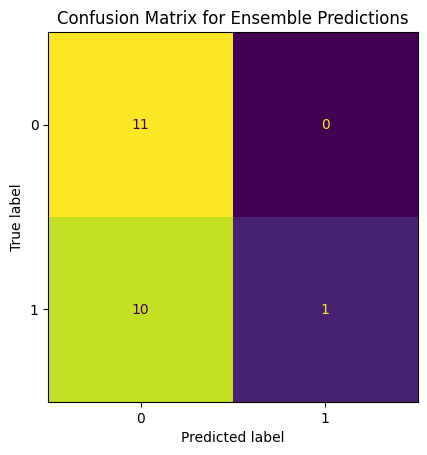

In [23]:
# Compute confusion matrices for each model
vgg_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['2_pred'])
ensemble_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])

# Plot confusion matrix for VGG-19
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=vgg_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for VGG-19 Predictions")
plt.show()

# Plot confusion matrix for ResNet-50
plt.figure(figsize=(6, 6))
resnet_disp = ConfusionMatrixDisplay(confusion_matrix=resnet_conf_matrix)
resnet_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for ResNet-50 Predictions")
plt.show()

# Plot confusion matrix for Ensemble
plt.figure(figsize=(6, 6))
ensemble_disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_conf_matrix)
ensemble_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Ensemble Predictions")
plt.show()

#### Test 3

In [12]:
import time
# Check if a GPU is available and set the device accordingly
device = torch.device("cpu")

# Function to perform ensemble prediction and measure inference time
def ensemble_predict(vgg_model, resnet_model, test_loader):
    predictions = {'label': [], '1_pred': [], '2_pred': [], 'ensemble_pred': []}
    total_vgg_time = 0  # To track the total inference time for VGG-19
    total_resnet_time = 0  # To track the total inference time for ResNet-50
    total_ensemble_time = 0  # To track the total ensemble inference time
    
    with torch.no_grad():
        for data, target in test_loader:
            start_ensemble_time = time.time()
            data = data.to(device)  # Move data to the same device as the models (GPU/CPU)
            target = target.to(device)  # Move labels to the device
            
            # Measure time for VGG-19 prediction
            start_vgg_time = time.time()
            vgg_output = vgg_model(data)
            end_vgg_time = time.time()
            total_vgg_time += (end_vgg_time - start_vgg_time)
            _, vgg_pred = torch.max(vgg_output, 1)
            
            # Measure time for ResNet-50 prediction
            start_resnet_time = time.time()
            resnet_output = resnet_model(data)
            end_resnet_time = time.time()
            total_resnet_time += (end_resnet_time - start_resnet_time)
            _, resnet_pred = torch.max(resnet_output, 1)
            
            # Measure time for ensemble prediction
            
            ensemble_pred = (vgg_output + resnet_output) / 2
            end_ensemble_time = time.time()
            total_ensemble_time += (end_ensemble_time - start_ensemble_time)
            _, final_ensemble_pred = torch.max(ensemble_pred, 1)
            
            # Store predictions
            predictions['label'].extend(target.cpu().tolist())
            predictions['1_pred'].extend(vgg_pred.cpu().tolist())
            predictions['2_pred'].extend(resnet_pred.cpu().tolist())
            predictions['ensemble_pred'].extend(final_ensemble_pred.cpu().tolist())
    
    # Return predictions and the individual model inference times
    return predictions, total_vgg_time, total_resnet_time, total_ensemble_time

# Perform ensemble prediction and measure total inference times for both models and the ensemble
ensemble_predictions, total_vgg_time, total_resnet_time, total_ensemble_time = ensemble_predict(vgg19_model, resnet50_model, test_data_loader)

# Calculate total number of images in the test dataset
num_images = len(ensemble_predictions['label'])

# Calculate average inference time per image for VGG-19, ResNet-50, and the ensemble
average_vgg_inference_time = total_vgg_time / num_images
average_resnet_inference_time = total_resnet_time / num_images
average_ensemble_inference_time = total_ensemble_time / num_images

# Print the average inference times
print(f"VGG-19 average inference time per image: {average_vgg_inference_time:.6f} seconds")
print(f"ResNet-50 average inference time per image: {average_resnet_inference_time:.6f} seconds")
print(f"Ensemble average inference time per image: {average_ensemble_inference_time:.6f} seconds")

# Proceed with evaluating models and computing metrics
vgg_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['1_pred'], average='weighted')
resnet_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['2_pred'], average='weighted')
vgg_f2 = f2_score(vgg_precision, vgg_recall)
resnet_f2 = f2_score(resnet_precision, resnet_recall)
vgg_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['2_pred'])

ensemble_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])
ensemble_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_precision = precision_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')
ensemble_f2 = f2_score(ensemble_precision, ensemble_recall)

print("********************************")
print(f'Ensemble F2 score: {ensemble_f2}')
print(f'VGG-19 F2 score: {vgg_f2}')
print(f'ResNet-50 F2 score: {resnet_f2}')
print("********************************")
print(f'Ensemble accuracy: {ensemble_acc}')
print(f'VGG-19 accuracy: {vgg_acc}')
print(f'ResNet-50 accuracy: {resnet_acc}')
print("********************************")
print(f'Ensemble recall: {ensemble_recall}')
print(f'VGG-19 recall: {vgg_recall}')
print(f'ResNet-50 recall: {resnet_recall}')
print("********************************")
print(f'Ensemble precison: {ensemble_precision}')
print(f'VGG-19 precision: {vgg_precision}')
print(f'ResNet-50 precision: {resnet_precision}')

VGG-19 average inference time per image: 0.055321 seconds
ResNet-50 average inference time per image: 0.045362 seconds
Ensemble average inference time per image: 0.100729 seconds
********************************
Ensemble F2 score: 0.5549510337323177
VGG-19 F2 score: 0.44333076329992294
ResNet-50 F2 score: 0.5
********************************
Ensemble accuracy: 0.5454545454545454
VGG-19 accuracy: 0.45454545454545453
ResNet-50 accuracy: 0.5
********************************
Ensemble recall: 0.5454545454545454
VGG-19 recall: 0.45454545454545453
ResNet-50 recall: 0.5
********************************
Ensemble precison: 0.5964912280701754
VGG-19 precision: 0.40350877192982454
ResNet-50 precision: 0.5


<Figure size 600x600 with 0 Axes>

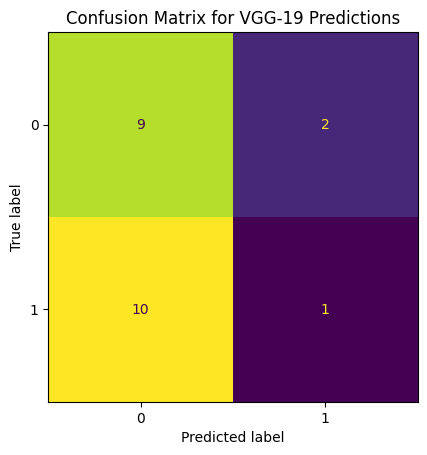

<Figure size 600x600 with 0 Axes>

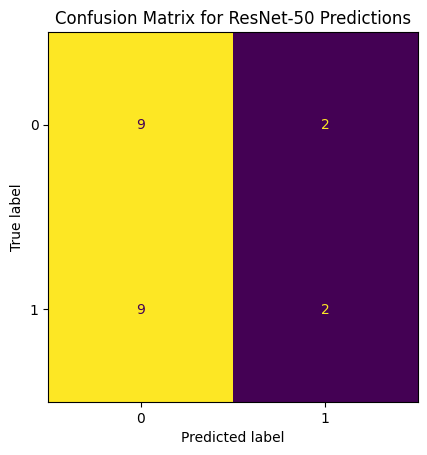

<Figure size 600x600 with 0 Axes>

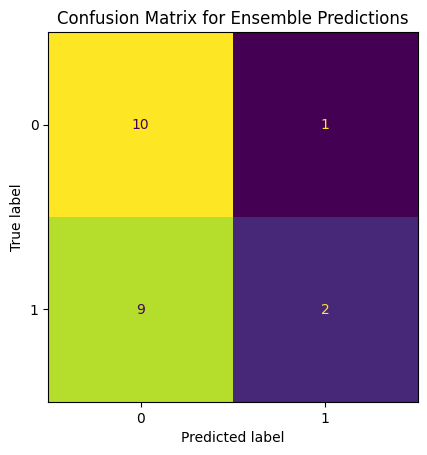

In [18]:
# Compute confusion matrices for each model
vgg_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['1_pred'])
resnet_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['2_pred'])
ensemble_conf_matrix = confusion_matrix(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])

# Plot confusion matrix for VGG-19
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=vgg_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for VGG-19 Predictions")
plt.show()

# Plot confusion matrix for ResNet-50
plt.figure(figsize=(6, 6))
resnet_disp = ConfusionMatrixDisplay(confusion_matrix=resnet_conf_matrix)
resnet_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for ResNet-50 Predictions")
plt.show()

# Plot confusion matrix for Ensemble
plt.figure(figsize=(6, 6))
ensemble_disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_conf_matrix)
ensemble_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Ensemble Predictions")
plt.show()